In [178]:
import pandas as pd
import datetime as dt
import seaborn as sns
import pingouin as pg
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from time import strftime, localtime
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import norm
from tqdm.auto import tqdm

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 
    Задание 1
Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

    Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

    Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

 

# Задание 1

In [179]:
reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-skurlatova-33/shared/problem1-reg_data.csv',sep=';')
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [180]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [181]:
auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-skurlatova-33/shared/problem1-auth_data.csv',sep=';')
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [182]:
auth.info()
auth.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


auth_ts    0
uid        0
dtype: int64

In [183]:
auth.duplicated().value_counts()

False    9601013
dtype: int64

In [184]:
reg.duplicated().value_counts()

False    1000000
dtype: int64

По результатам проведенного EDA null-значний и дубликатов в датасетах не выявленно. Так как время в обоих таблицах представлено в unix формате, для наглядности переведу его в привычный формат для того, чтобы понять, в каких временных границах существуют данные.

In [185]:
reg['reg_ts']=reg.reg_ts.apply(lambda x:strftime('%Y-%m-%d', localtime(x)))
auth['auth_ts']=auth.auth_ts.apply(lambda x:strftime('%Y-%m-%d', localtime(x)))

In [186]:
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'])
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'])

In [187]:
auth.auth_ts.min() 

Timestamp('1998-11-18 00:00:00')

In [188]:
auth.auth_ts.max()

Timestamp('2020-09-23 00:00:00')

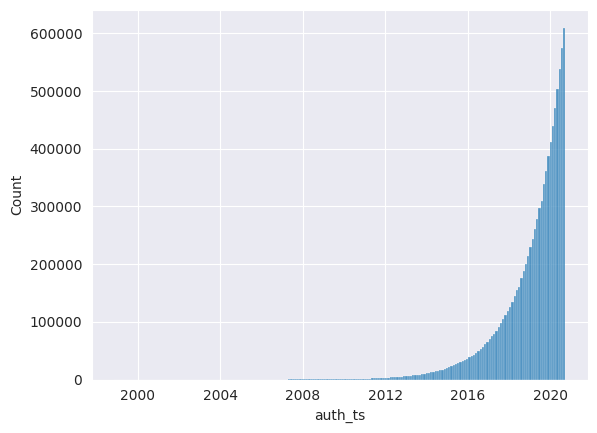

In [189]:
sns.histplot(x=auth.auth_ts,bins=200)

Наибольшая активность пользователей наблюдается в 2020 году, 
поэтому возьму временной интервал для сэмпла 1 января 2020г. - 23 сентября 2020г. (конец регистрации действий пользователей)

In [190]:
#sample
reg_2020 = reg.query('reg_ts>="2020-01-01" & reg_ts<="2020-09-22"')
auth_2020 = auth.query('auth_ts>="2020-01-01" & auth_ts<="2020-09-23"')

Создам функцию расчета retention и проверю ее работу на сэмпле данных за 2020 год

In [191]:
def retention_rate(df_reg,df_auth):
    all_data = df_auth.merge(df_reg, how='left',on='uid')
    if (all_data.reg_ts.astype('datetime64[ns]') is False) & (all_data.auth_ts.astype('datetime64[ns]') is False):
        all_data['reg_ts']=all_data.reg_ts.apply(lambda x:strftime('%Y-%m-%d', localtime(x))) 
        all_data['auth_ts']=all_data.auth_ts.apply(lambda x:strftime('%Y-%m-%d', localtime(x)))
        all_data['reg_ts'] = pd.to_datetime(all_data['reg_ts'])
        all_data['auth_ts'] = pd.to_datetime(all_data['auth_ts'])
    
    all_data['days_since_reg'] = (all_data['auth_ts'] - all_data['reg_ts']).dt.days
    all_data = all_data[['uid','days_since_reg']]
    all_data = all_data.groupby('days_since_reg',as_index=False)\
                   .agg({'uid':'nunique'})\
                   .rename(columns={'uid':'id_count'})
    all_data['retention'] = (all_data['id_count']/all_data.id_count[0])*100
    all_data['retention'] = all_data.retention.round(2)
    all_data = all_data[['days_since_reg','retention']]
    
    #визуализация
    plt.subplots(figsize=(12, 5))
    sns.set_style("darkgrid")
    sns.lineplot(x=all_data.days_since_reg, y=all_data.retention,color='teal')\
       .set( xlabel='Days since registration', ylabel='Retention')
    plt.show()
    
    return all_data

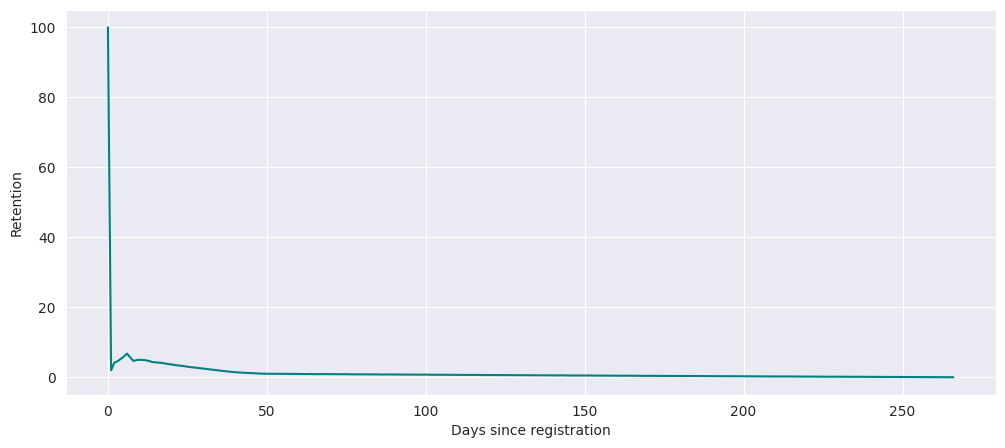

,days_since_reg,retention
0,0.0,100.00
1,1.0,1.99
2,2.0,4.11
3,3.0,4.56
4,4.0,5.20
...,...,...
262,262.0,0.02
263,263.0,0.02
264,264.0,0.01
265,265.0,0.01


In [192]:
retention_rate(reg_2020,auth_2020)

# Задание 2

In [193]:
path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
data = pd.read_csv(path,sep=';')
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


После загрузки датасета проведу краткий EDA

In [194]:
data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [195]:
data.shape[0]

404770

In [196]:
data.user_id.nunique()

404770

В таблице имеются только уникальные пользатели

In [197]:
data.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Количество пользователей в группах примерно одинаковое

In [198]:
data.groupby('testgroup',as_index=False).agg({'revenue':'sum'})

,testgroup,revenue
0,a,5136189
1,b,5421603


In [199]:
data.groupby('testgroup',as_index=False).agg({'revenue':'mean'})

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [200]:
data.groupby('testgroup',as_index=False).agg({'revenue':'median'})

,testgroup,revenue
0,a,0
1,b,0


Проверю, соответствует ли ARPU условиям задачи:

In [201]:
arpu=data.groupby('testgroup',as_index=False).agg({'revenue':'sum','user_id':'nunique'})
arpu['arpu'] = arpu['revenue']/arpu['user_id']
arpu

,testgroup,revenue,user_id,arpu
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


In [202]:
100-(arpu.arpu[0]/arpu.arpu[1])*100 #соответствует

5.000009444962146

Рассчитаю также ARPPU для того, чтобы в дальнейшем исследовать изменения среди платящих юзеров на статзначимость

In [203]:
arppu = data.query('revenue>0')\
            .groupby('testgroup',as_index=False)\
            .agg({'revenue':'sum','user_id':'nunique'})
arppu['arppu'] = arppu['revenue']/arppu['user_id']
arppu

,testgroup,revenue,user_id,arppu
0,a,5136189,1928,2663.998444
1,b,5421603,1805,3003.658172


In [204]:
100-(arppu.arppu[0]/arppu.arppu[1])*100 

11.308201810607642

Метрика ARPPU в тестовой группе увеличилась на 11% по сравнению с контрольной, хотя платящих клиентов стало меньше.

Также рассчитаю конверсию в покупку в обоих группах. Эта метрика поможет понять, в группе с каким набором акционных предложений пользователи охотнее конвертировались в покупку.

In [205]:
CR = (arppu.user_id/arpu.user_id)*100
CR

0    0.953969
1    0.890624
Name: user_id, dtype: float64

В тестовой группе конверсия в покупку наоборот снизилась относительно конверсии в покупку в контрольной группе на 6 процентных пунктов

Для того, чтобы понять, явились ли изменения по подсчитанным метрикам в двух группах статзначимыми, проведу тесты. Выделю исследуемые группы в отдельные датасеты. Мне интересен параметр выручки, поэтому оставлю данные только по revenue

In [206]:
group_a = data.query('testgroup=="a"')['revenue'].to_frame()

In [207]:
group_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202103 entries, 1 to 404768
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   revenue  202103 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [208]:
group_a.describe()

,revenue
count,202103.000000
mean,25.413720
std,920.768137
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,37433.000000


Для того, чтобы определить, каким тестом воспользоваться, исследую данные на нормальность распределения.

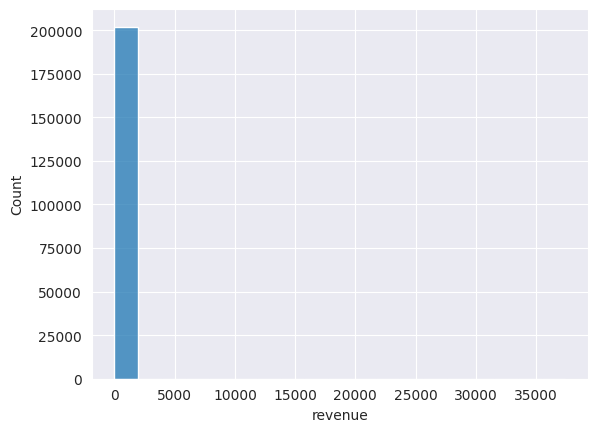

In [209]:
sns.histplot(group_a.revenue)

In [210]:
pg.normality(group_a, method='normaltest')

,W,pval,normal
revenue,585152.731273,0.0,False


In [211]:
group_b = data.query('testgroup=="b"')['revenue'].to_frame()

In [212]:
group_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202667 entries, 0 to 404769
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   revenue  202667 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [213]:
group_b.describe()

,revenue
count,202667.000000
mean,26.751287
std,287.324162
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4000.000000


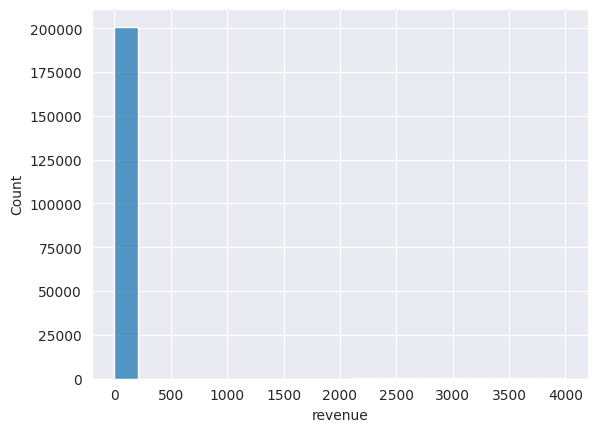

In [215]:
sns.histplot(group_b.revenue)

In [216]:
pg.normality(group_b, method='normaltest')

,W,pval,normal
revenue,326622.395409,0.0,False


Дополнительно проверю, соблюдается ли требование гомогенности дисперсий в группах. Для этого буду использовать тест Лавена. Нулевая гипотеза - дисперсии должны быть примерно одинаковые.

In [217]:
scipy.stats.levene(group_a.revenue, group_b.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Полученное в результате теста Лавена значение p-value значительно превосходит уровень значимости в 5%. Значит принимаю нулевую гипотезу.
Однако распределения выручки не являются нормальными в обоих исследуемых группах. Для больших выборок ненормальность распределения не столь критична, но в контрольной группе присутствуют значительные выбросы, поэтому возникает риск допустить ошибку первого рода при использовании t-теста.

В этом случае целесообразно провести непараметрический тест Манна-Уитни и Bootstrap для поиска статзначимых различий в двух исследуемых группах.

За нулевую гипотезу приму отсутствие различия в группах. Значение альфа возьму 0.05

In [218]:
mannwhitneyu(group_a.revenue,group_b.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Тест Манна-Уитни не дал статзначимого результата. Проведу тест бутстрап оценки средних. Оценку медиан проводить не буду, так как о обоих группах медианное значение равно 0.

In [219]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it, 
    statistic,
    bootstrap_conf_level 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return { "p_value": p_value}

In [220]:
get_bootstrap(
    group_a.revenue, 
    group_b.revenue, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
)

{'p_value': 0.544151162080825}

В результате проведения теста бутстрап оценки средних полученное значение p-value в разы превышает альфу. Таким образом отвергнуть нулевую гипотезу пока не представляется возможным, а полученное значение ARPU тестовой группы, превышающее ARPU контрольной не является статзначимым.

Выделю только платящих юзеров:

In [221]:
group_a_pay = group_a.query('revenue>0')
group_a_pay.head()

,revenue
72,351
341,290
385,250
416,37324
712,255


Проверю выборки на наличие повторяющихся значений. Большое их количество может повлиять на адекватность проведения теста Манна-Уитни

In [222]:
group_a_pay.duplicated().value_counts()

True     1660
False     268
dtype: int64

In [223]:
pg.normality(group_a_pay.revenue, method='normaltest')

,W,pval,normal
revenue,1394.945784,1.234161e-303,False


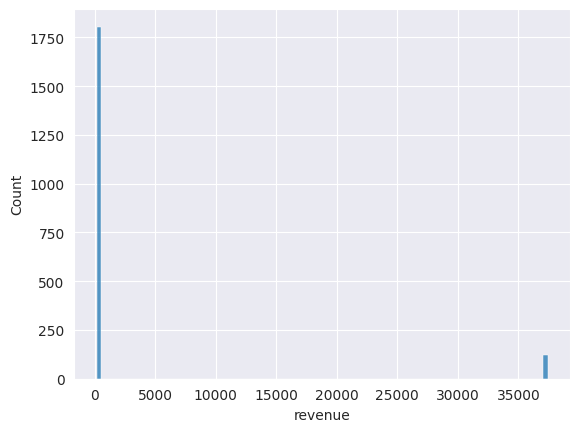

In [227]:
sns.histplot(group_a_pay.revenue,bins=100)

Среди пользователей контрольной группы есть те, кто совершил покупки более чем на 35 тыс. Определю, много ли таких:

In [228]:
group_a_pay.query('revenue>35000').count()

revenue    123
dtype: int64

Так как в исходном датасете представлены только уникальные пользователи, делаю вывод, что по результатам подсчетов в контольной группе есть 123 пользователя, потративших более 35 тыс. Непонятно, являются ли эти данные случайными выбросами или реальными тратами, поэтому от экстримальных значений избавляться не буду. Возможно, для достижения нормального распределения поможет логарифмирование.

/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-skurlatova-33/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


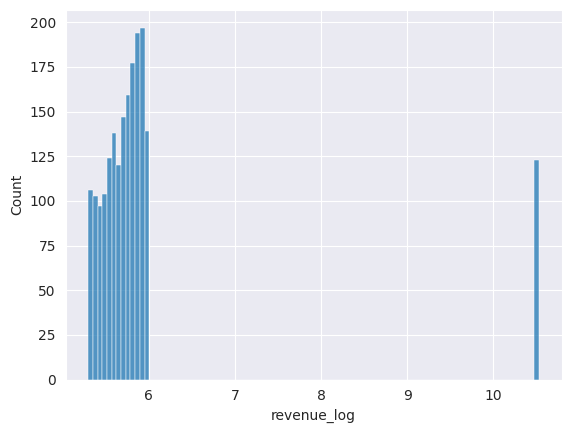

In [229]:
group_a_pay['revenue_log'] = np.log(group_a_pay.revenue)
sns.histplot(group_a_pay.revenue_log) #выбросы остались

In [230]:
pg.normality(group_a_pay['revenue_log'], method='normaltest') 
#после логарифмирование распределение осталось ненормальным 

,W,pval,normal
revenue_log,1340.721406,7.345912e-292,False


Исследую тестовую группу на нормальность распределения и наличие повторяющихся значений.

In [232]:
group_b_pay = group_b.query('revenue>0')
group_b_pay.duplicated().value_counts()

False    1208
True      597
dtype: int64

In [233]:
pg.normality(group_b_pay['revenue'], method='normaltest')

,W,pval,normal
revenue,1068.860008,7.943249e-233,False


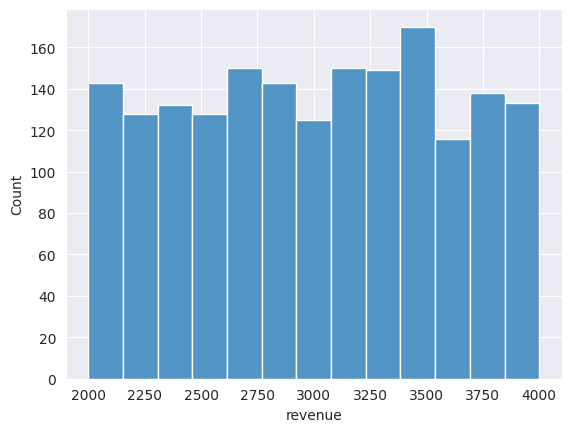

In [234]:
sns.histplot(group_b_pay.revenue)

/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-skurlatova-33/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


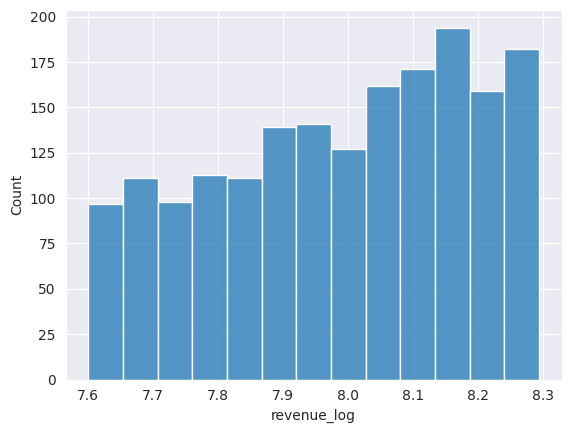

In [235]:
group_b_pay['revenue_log'] = np.log(group_b_pay.revenue)
sns.histplot(group_b_pay.revenue_log)

In [236]:
pg.normality(group_b_pay['revenue_log'], method='normaltest')

,W,pval,normal
revenue_log,594.784923,6.983850e-130,False


In [237]:
scipy.stats.levene(group_a_pay.revenue, group_b_pay.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Распределения не являются нормальными. Даже после логарифмирования. Тест Лавена показал статзначимый результат. Параметрические тесты тут не подойдут. Проведу те же тесты, однако, добавлю бутстрап с оценкой медианы.

Перед тем, как проводить тест Манна-Уитни хочу обратить внимание на большое количество повторяющихся значений в обоих исследуемых группах. 

In [238]:
mannwhitneyu(group_a_pay.revenue,group_b_pay.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Тест Манна-Уитни дал статзначимый результат. Однако, критерий Манна-Уитни проверяет верность нулевой гипотезы о равенстве распределений (случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки).
https://koch-kir.medium.com/история-одного-обмана-или-требования-к-распределению-в-статистических-тестах-55139a5558d тут его делать не советуют.

In [239]:
group_a_pay.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [240]:
group_b_pay.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [241]:
get_bootstrap(
    group_a_pay.revenue, 
    group_b_pay.revenue, 
    boot_it = 1000, 
    statistic = np.median, 
    bootstrap_conf_level = 0.95 
)

{'p_value': 0.0}

In [242]:
get_bootstrap(
    group_a_pay.revenue, 
    group_b_pay.revenue, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
)

{'p_value': 0.11013963603393583}

По результатам теста бутстрап с оценкой медиан получился статзначимый результат (медианное значение тестовой группы почти в 10 раз больше,чем в контрольной), однако тот же бутстрап с оценкой среднего дал значение p-value значительно превышающее пороговое.Пока сделать вывод о выборе набора предложений сложно.

Также проведу тест на оценку статзначимости изменения конверсии в покупку. По результатам A/B теста были получены следующие данные: в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

За нулевую гипотезу приму отсутствие различий в исследуемых группах. Уровень значимости (альфа) = 0.05

Для оценки статзначимости изменения конверсии воспользуюсь критерием Хи-квадрат, который часто используется для проверки гипотез A/B тестов в сравнении конверсий.

In [243]:
df = data.groupby('testgroup',as_index=False)['user_id'].count()\
         .rename(columns={'user_id':'all_users'})

In [244]:
dff = data.query('revenue>0').groupby('testgroup',as_index=False)['user_id'].count()\
          .rename(columns={'user_id':'paying_users'})

In [245]:
df = df.set_index('testgroup').join(dff.set_index('testgroup'))
df

,all_users,paying_users
testgroup,,
a,202103,1928
b,202667,1805


In [246]:
result = np.array([[df.paying_users[0],df.all_users[0]],[df.paying_users[1],df.all_users[1]]])

In [247]:
scipy.stats.chi2_contingency(result)

(4.294148751290091,
 0.03824373651044168,
 1,
 array([[  1864.48501725, 202166.51498275],
        [  1868.51498275, 202603.48501725]]))

По итогам теста получился статзначимый результат. P-value 0.038, что меньше выбранного значения альфа.

Так как имеется таблица сопряженности 2х2, есть смысл проверить статзначимость результатов, воспользовавшись точным тестом Фишера.

In [248]:
fisher_exact([[df.paying_users[0],df.all_users[0]],[df.paying_users[1],df.all_users[1]]])

(1.0711248671740197, 0.03679148517562236)

Полученное значение p-value (~  0.037) также меньше выбранного значения альфа, что говорит о наличии статзначимых различий в вариантах, соответственно, и о возможности отвергнуть нулевую гипотезу.

# Выводы

 По результатам проведенных тестов сложно сделать какие-то однозначные выводы. Рост ARPU на 5 % не оказался статзначимым, поэтому выбрать тестовый вариант акционных предложений по этой метрике не является целесообразным. 
 
 Однако получен статзначимый результат в оценке медиан бутстрапом по метрике ARPPU (которая в тестовой группе выросла на 11%). По параметру оценки среднего результат не является статзначимым. Также получено значение p-value < 0.05 при использовании непараментического теста Манна-Уитни (но особого доверия к нему нет). Так как прибыль в контрольной и тестовой группе распределены неравномерно (в контрольной группе 123 пользователя из 1928 платящих, что составляет 6.4%, имели экстримально высокие чеки, природа которых мне неизвестна (можно было бы проследить на исторических данных)), поэтому медианные значения групп имеют такие различия. В качестве предложения, дабы не допустить ошибку первого рода, можно поинтересоваться у бизнеса, какие пользователи представлют бОльшую ценность или проследить будет ли поведение пользователей с большими чеками регулярным или было случайным. 
 
 По метрике конверсии получен также статзначимый результат. Но так как конверсия в контрольной группе выше, чем в тестовой, это дает основание выбрать акционный пакет предложений контрольной группы по данной метрике.

# Задание 3

Важно понимать, для чего проводятся данные тематические события. В моем представлении для удержания пользователей и увеличения метрики retention. Если игроки получают какие-то бонусы, их заинтересованность растет, это способствует более продолжительному жизненному циклу в игре. Если в игре есть также какие-то платные артефакты и бонусы, пользователь, получивший подобное в бонусном эвенте и применив  это в повседневной игровой деятельности, захочет купить дополнительные предметы или монеты уже за реальные деньги.

Обычная механика события

-  Процент игроков от общего количества активных юзеров, которые приняли участие в тематическом событии.

-  Сколько игроков в процентном соотношении прошли успешно все уровни и получили бонусы относительно всех участников события.

-  Сезонность (часовая с разбивкой на когорты пользователей из разных часовых поясов; дневная, если продолжительность события более 24 часов).

-  DAU до события и после для того, чтобы понять, стимулируют ли подобные бонусные эвенты играть чаще.

-  Конверсия  (абсолютная и относительная) в прохождение следующего уровня.

-  Длина сессии (Session Length) каждого игрока, а также Average session length всех игроков.

-  Проходит ли игрок тематическое событие за одну сессию или несколько (Session count). Зависит от длительности события и возможности пройти его за несколько раз.

-  Среднее количество пройденных уровней.

-  Среднее время прохождения уровня для оценки сложности тематического события (нам важно, чтобы событие было не очень сложное, чтобы привлечь игроков на последующие подобные события, но и не слишком простое, чтобы все участники тематического эвента не получили бонусы).

-  Также в подобном событии мы можем показывать рекламу от наших партнеров, что способствует дополнительным доходам и соответственно посчитать CTR.

-  После прохождения ряда уровней, независимо от того, получил игрок бонусы или нет, предложить оценить свою удовлетворенность событием (Customer satisfaction score).

В усложненной механике к  предложенным метрикам в предыдущем стейтменте я бы добавила churn rate для каждого уровня, чтобы понять, какой из уровней является самым проблемным для игроков, и какой процент отваливается вообще. 
Также можно оценить, сколько раз игроки откатываются назад на неудачных уровнях, сколько раз они проходят те же неудачные уровни повторно.
После первого тематического события с усложненной механикой сравнить Customer Satisfaction score этого эвента и предыдущего.
